In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

In [2]:
def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise ValueError( 
                "Input vectors y_axis and x_axis must have same length")
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis

In [3]:
def peakdetect(y_axis, x_axis = None, lookahead = 200, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    ##note li zhou: also cite Converted from MATLAB script at http://billauer.co.il/peakdet.html
    function for detecting local maxima and minima in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maxima and minima respectively
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks. If omitted an
        index of the y_axis is used.
        (default: None)
    
    lookahead -- distance to look ahead from a peak candidate to determine if
        it is the actual peak
        (default: 200) 
        '(samples / period) / f' where '4 >= f >= 1.25' might be a good value
    
    delta -- this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            When omitted delta function causes a 20% decrease in speed.
            When used Correctly it can double the speed of the function
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        #no peaks were found, should the function return empty lists?
        pass
        
    return [max_peaks, min_peaks]

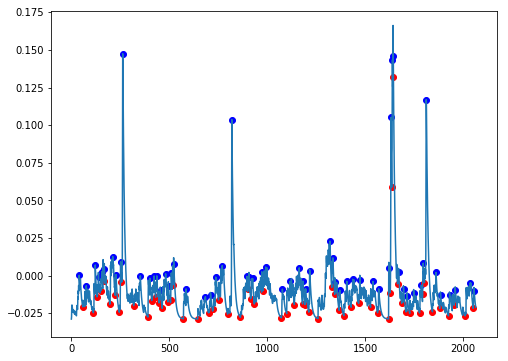

In [4]:
# need to run the above def peakdet
from matplotlib.pyplot import plot, scatter, show
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

SelectCell = 49

Cal_temp_C = np.load('Cal_temp_C.npy')
idx_components = np.load('cnm.estimates.idx_components.npy')
Cal_temp_C = Cal_temp_C[idx_components] #select good trace

x = Cal_temp_C[:,:]#slicing the pharmacology time, sampling at 1 Hz. 
standardized_X = preprocessing.normalize(x,norm = "l2", axis=1) # row norm, 'L2' not '12'

series = standardized_X[SelectCell,:]

maxtab, mintab = peakdetect(y_axis=series, x_axis = None, lookahead = 1, delta=0.01)

fig,ax = plt.subplots(figsize=(8,6))
plot(series)
# scatter(maxtab[:,0], maxtab[:,1], color='blue')
# scatter(mintab[:,0], mintab[:,1], color='red')
scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='blue')
scatter(np.array(mintab)[:,0], np.array(mintab)[:,1], color='red')
# plt.savefig('peaktest.png',dpi=300)
show()
# anp=np.array(maxtab)  
# anp

In [5]:
def calcium_peaks(data):
    ls = []
    row,col = data.shape
    for i in range(0,row):
        row_data=data[i,:]
        maxtab, mintab = peakdetect(y_axis=row_data, x_axis = None, lookahead = 1, delta=0.01)
        ls.append(maxtab)

    return ls

In [6]:

Cal_temp_C = np.load('Cal_temp_C.npy')
idx_components = np.load('cnm.estimates.idx_components.npy')
Cal_temp_C = Cal_temp_C[idx_components] #select good trace

x = Cal_temp_C[:,:]#slicing the pharmacology time, sampling at 1 Hz. 
standardized_X = preprocessing.normalize(x,norm = "l2", axis=1) # row norm, 'L2' not '12'

testdata = standardized_X
testresult = calcium_peaks(testdata)
    
print(len(testresult))
testresult[0]

87


[[270, 0.009434766602239367],
 [344, 0.022819803620277017],
 [472, 0.015194826183756931],
 [527, 0.09311006139431902],
 [587, 0.09339245341125293],
 [652, 0.04528368928099162],
 [703, 0.04424665571036929],
 [887, 0.028440305213544046],
 [938, 0.02551714078934444],
 [1090, 0.02641471279719363],
 [1189, 0.02660187282944563],
 [1291, 0.023062495024309005],
 [1772, 0.04018917835720727]]

In [7]:
before = []
after = []
for x in range(0,len(testresult)):
    i100_300 =0
    i400_600 =0
    for i in testresult[x]:

        if 400<i[0]<500:
            i100_300+=1
        if 500<i[0]<600:
            i400_600+=1
    before.append(i100_300)
    after.append(i400_600)

print(before)
print(np.mean(before))
print('-------------')
print(after)
print(np.mean(after))

[1, 3, 0, 0, 1, 0, 2, 0, 7, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 4, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 5, 6, 0, 0, 0, 2, 1, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 2, 2, 0, 0, 5, 0]
0.9425287356321839
-------------
[2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 5, 5, 6, 3, 1, 1, 2, 1, 3, 2, 6, 0, 1, 0, 2, 0, 0, 1, 1, 1, 2, 3, 3, 2, 2, 3, 1, 4, 0, 2, 0, 1, 1, 1, 6, 3, 2, 3, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 3, 1, 0, 2, 0, 4, 2, 0, 2, 0, 3, 2, 1, 0, 5, 1, 1, 1, 0, 2, 2, 1, 1, 4, 0, 4, 1]
1.5402298850574712


In [8]:
a = np.array(before)
np.where(a > 5)
a_drop = np.where(a >= 5)
print(a_drop)
# dropls = a_drop[0].tolist()
#preserve 46,84,111,228,235,243,246,249
dropls =[8,49]
drop = dropls.copy()

(array([ 8, 48, 49, 85], dtype=int64),)


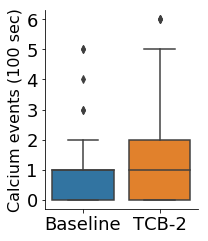

In [9]:
#data preparation: list to dataframe, transpose, and wide_to _long format

df1 = pd.DataFrame(before, columns = ['Baseline'])
df2 = pd.DataFrame(after,columns = ['TCB-2'])
df1.drop(index=dropls, inplace=True)
df2.drop(index=dropls, inplace=True)
df = pd.concat([df1,df2],axis = 1)
# print(df)
# print(df.head())
#df = pd.DataFrame([before,after],index=['before','after'])


#df = df.T # or df.transpose()  # no need here

df = pd.melt(df,value_vars=['Baseline', 'TCB-2']) # wide_to _long format
df.tail()


#violin plot and 
import seaborn as sns

fig,ax = plt.subplots(figsize=(3,3.5))

ax=sns.boxplot(x="variable", y="value", data=df);
# ax=sns.swarmplot(x="variable", y="value", data=df, color="white", edgecolor="grey", linewidth=0.5,size=6,dodge=True)
ax.set(title = '', xlabel = "", ylabel='Calcium events (100 sec)',)
sns.despine() #magic to remove the x-top , and y-right axis
plt.ylabel('Calcium events (100 sec)',fontsize=16)

plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

plt.tight_layout()
# ax.set(yscale="log")
plt.savefig("box_TCB2_curated.png",dpi=300)

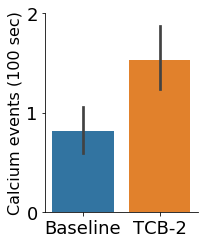

In [27]:
fig,ax = plt.subplots(figsize=(3,3.5))

ax=sns.barplot(x="variable", y="value", data=df);
#ax=sns.swarmplot(x="variable", y="value", data=df, color="white", edgecolor="grey", linewidth=0.5,size=6,dodge=True)
ax.set(title = '', xlabel = "", ylabel='Calcium events (100 s)')

plt.yticks(range(0,3,1))
plt.ylabel('Calcium events (100 sec)',fontsize=16)

plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
sns.despine() #magic to remove the x-top , and y-right axis

plt.tight_layout()
plt.savefig("bar_TCB2_curated.png",dpi=300)



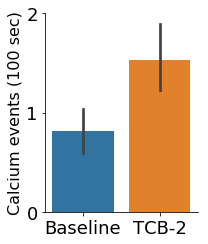

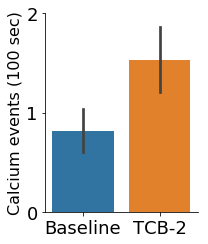

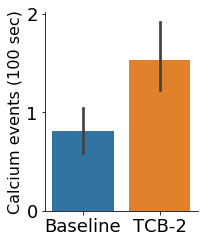

In [31]:
fig,ax = plt.subplots(figsize=(3,3.5))

ax=sns.barplot(x="variable", y="value", data=df,ci=95);
#ax=sns.swarmplot(x="variable", y="value", data=df, color="white", edgecolor="grey", linewidth=0.5,size=6,dodge=True)
ax.set(title = '', xlabel = "", ylabel='Calcium events (100 s)')

plt.yticks(range(0,3,1))
plt.ylabel('Calcium events (100 sec)',fontsize=16)

plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)
sns.despine() #magic to remove the x-top , and y-right axis

plt.tight_layout()
plt.savefig("bar_TCB2_curated_ci95.png",dpi=300)



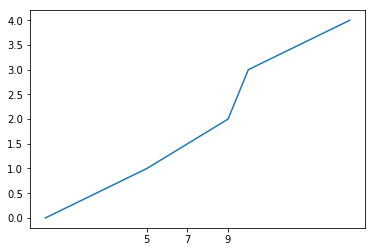

In [68]:
x = [0,5,9,10,15]
y = [0,1,2,3,4]
plt.plot(x,y)
plt.xticks(np.arange(5, 10, 2))
plt.show()

In [49]:
from scipy import stats
print(stats.ttest_rel(df[df["variable"]=='Baseline']['value'],df[df["variable"]=='TCB-2']['value'])) #independent, paired t test

Ttest_relResult(statistic=-4.0228456016868055, pvalue=0.0001251823177106555)


In [48]:
df[df["variable"]=='Baseline']['value']

0     1
1     3
2     0
3     0
4     1
     ..
80    2
81    0
82    0
83    5
84    0
Name: value, Length: 85, dtype: int64

Ttest_relResult(statistic=-4.177612764730694, pvalue=7.043674443204742e-05)


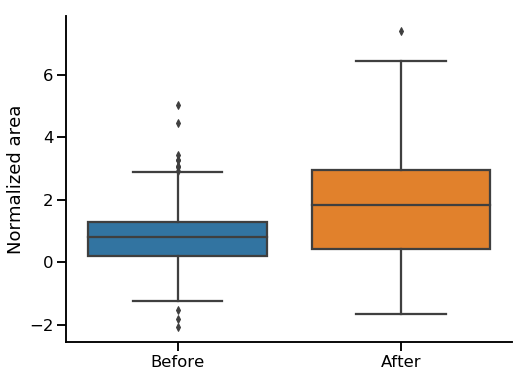

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from numpy import trapz


Cal_temp_C = np.load('Cal_temp_C.npy')
idx_components = np.load('cnm.estimates.idx_components.npy')
Cal_temp_C = Cal_temp_C[idx_components] #select good trace

x = Cal_temp_C[:,:]#slicing the pharmacology time, sampling at 1 Hz. 
standardized_X = preprocessing.normalize(x,norm = "l2", axis=1) # row norm

ab= standardized_X[:,400:500]
ap= standardized_X[:,500:600]

#print(ab.shape)

def trapz_area(row):
    return trapz(row, dx=1)

dfab = pd.DataFrame(ab)
dfap = pd.DataFrame(ap)



#dfap = pd.DataFrame(ap)
dfab['area']=dfab.apply(trapz_area,axis=1)
dfap['area']=dfap.apply(trapz_area,axis=1)

#print(dfap.head())
df1=pd.DataFrame()
df1['Before']=dfab['area']
df1['After']=dfap['area']
df = pd.melt(df1)
dfhold2=df.copy()



sns.set_context("talk") #paper, notebook, talk, and poster
#sns.set_style("white",{'ytick.left':True,'xtick.bottom': True,'ytick.right':False})

ax,fig = plt.subplots(figsize=(8,6))

ax=sns.boxplot(x="variable", y="value", data=df );
# ax=sns.swarmplot(x="variable", y="value", data=df, color="white", edgecolor="grey", linewidth=1)
ax.set(title = '', xlabel = "", ylabel='Normalized area')
sns.despine() #magic to remove the x-top , and y-right axis

# plt.savefig("box_second_pharma_p=.png",dpi=300)


from scipy import stats
print(stats.ttest_rel(df1['Before'],df1['After'])) #independent, paired t test

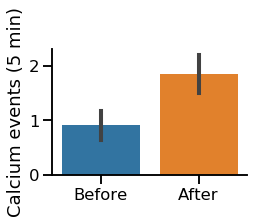

In [19]:
fig,ax = plt.subplots(figsize=(4,3))

ax=sns.barplot(x="variable", y="value", data=df);
#ax=sns.swarmplot(x="variable", y="value", data=df, color="white", edgecolor="grey", linewidth=0.5,size=6,dodge=True)
ax.set(title = '', xlabel = "", ylabel='Calcium events (5 min)')
sns.despine() #magic to remove the x-top , and y-right axis
plt.tight_layout()
# plt.savefig("bar_TTX_curated.png",dpi=300)

In [ ]:
fig,ax = plt.subplots(figsize=(4,3))

ax=sns.barplot(x="variable", y="value", data=df);
#ax=sns.swarmplot(x="variable", y="value", data=df, color="white", edgecolor="grey", linewidth=0.5,size=6,dodge=True)
ax.set(title = '', xlabel = "", ylabel='Calcium events (5 min)')
sns.despine() #magic to remove the x-top , and y-right axis
plt.tight_layout()
# plt.savefig("bar_TTX_curated.png",dpi=300)